In [2]:
# Import Packages
import pandas as pd
from edbo.utils import Data
import numpy as np
from edbo.bro import BO_express
from gpytorch.priors import GammaPrior
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output

In [3]:
#Create a parameter space
temperature_array = np.linspace(30,140,110,dtype=int)
time_array = np.linspace(10,45,35,dtype=int)
stoichiometry_array = np.linspace(33,66,33, dtype=int)

#EDBO uses lists not arrays
#convert parameter space to a list
temperature_list = temperature_array.tolist()
time_list = time_array.tolist()
stoichiometry_list = stoichiometry_array.tolist()

In [4]:
#parameters in reaction space
components = { 'temperature': temperature_list,              # discrete grid of temperatures
                'time': time_list,                           # discrete grid of time
                'stoichiometry': stoichiometry_list          # discrete grid of stoichiometry
                }

encoding = {'temperature':'numeric',                    #numerical encoding
            'time':'numeric',                           #numerical encoding
            'stoichiometry':'numeric'}                  #numerical encoding

In [5]:
from edbo.bro import BO_express

# BO object

bo = BO_express(components,                                 # Reaction parameters
                encoding=encoding,                          # Encoding specification
                acquisition_function='EI',                  # Use expectation value of improvement
                init_method='rand',                         # Use random initialization
                batch_size=3,                               # 3 experiments per round
                target='response')                          # Optimize response

# BO_express actually automatically chooses priors
# We can reset them manually to make sure they match the ones from our paper

from gpytorch.priors import GammaPrior

bo.lengthscale_prior = [GammaPrior(2.0, 0.2), 3.0]
bo.outputscale_prior = [GammaPrior(5.0, 0.5), 4.0]
bo.noise_prior = [GammaPrior(1.5, 0.5), 0.5]

In [6]:
#Plot Kriging beliver projection
def plot_kb_projections(n=2):
    """
    Plot 1D projection of Kriging believer parallel batch selection algorithm.
    """

    fig, ax = plt.subplots(len(bo.acq.function.projections[:n]),1, figsize=(12, n * 12 / 5))
    for i, p in enumerate(bo.acq.function.projections[:n]):
        ax[i].plot(range(len(p)), p, color='C' + str(i))
        ax[i].plot([np.argmax(p)], p[np.argmax(p)], 'X', markersize=10, color='black')
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('EI')
        ax[i].set_title('Kriging Believer Projection:' + str(i))
    
    plt.tight_layout()
    plt.show()

In [109]:
#Automate the workflow
def workflow(export_path):
    """
    Function for our BO pipeline.
    """
    
    bo.run()
    bo.plot_convergence()
    bo.model.regression()
    plot_kb_projections()
    bo.export_proposed(export_path)

In [8]:
#initialize the experiment
#Randomly select / Human select initial conditions
bo.init_sample(seed=1)                 # Initialize
bo.export_proposed('round1.csv')       # Export design to a CSV file
bo.get_experiments()                   # Print selected experiments

,temperature_index,time_index,stoichiometry_index
58945,81,11,40
63703,85,15,46
61230,83,10,48


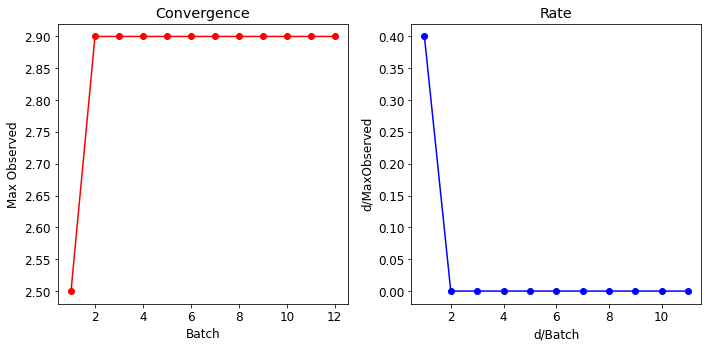

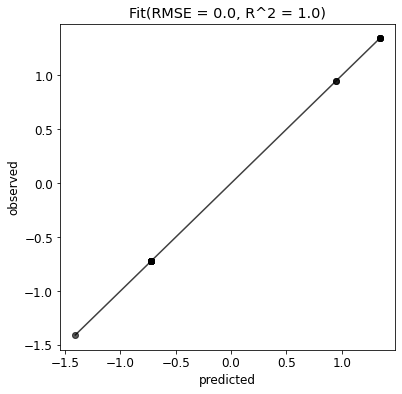

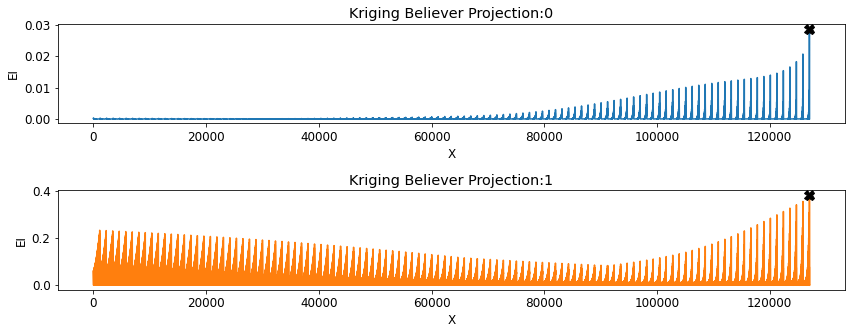

In [167]:
#Main Module 
#run this cell and add results/plots of current round, and make predictions for next experiment 
bo.add_results('results/round3.csv')       # Load real results from our experiments. This is the current round
workflow('round4.csv')                     # Run the workflow and export the next experiments. This is the next round

In [184]:
#function to get # of results run automatically 
#this number plugs into the function in the next cell automatically
result_round_counter= []
def test_this():

    directory = 'results'
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            result_round_counter.append(f)

print(len(result_round_counter))



0


In [187]:
#Plots for each round
#First plot shows selection of parameter space for each iteration 
#Second plot shows response at each round

df = pd.DataFrame()
result_round_counter= []
test_this()
# def plotly_plot(dataframe):



for i in range(1,len(result_round_counter)):
    file_name = pd.read_csv('results/round{}.csv'.format(i))
    file_name['Round'] = i
    file_name = file_name.astype({'Round':str})
    file_name = file_name.rename(columns={'Unnamed: 0':'parameter_space'})
    df = df.append(file_name,ignore_index=True)

fig3 = px.scatter_3d(df, x='temperature_index', y='time_index', z='stoichiometry_index', animation_frame = 'Round', color = 'response', hover_name = 'response', hover_data = ['response'])
fig3.update_traces(marker=dict(size=5))
fig3.show() 

fig = px.scatter(df, x='Round', y='response', color='Round')
fig.show() 

results/round0.csv
results/round1.csv
results/round2.csv
results/round3.csv
